# Análise da Influência de Variáveis Clínicas no Diagnóstico de Doença Angiográfica
Aplicação de Técnicas Estatísticas para Avaliação do Impacto na Presença de Doença Coronária.

## Objetivo
Este estudo tem como objetivo realizar uma análise sobre a influência de diversas variáveis clínicas e demográficas na presença ou ausência de doença angiográfica, com foco na identificação de fatores determinantes para o diagnóstico de doença coronária com o intuito de apoiar a tomada de decisões clínicas em ambientes médicos.

## Tratamento dos dados

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import os
datasetX = "./data/datasetX.csv"
datasety = "./data/datasety.csv"
data_dict_file = "data_dict_pt.csv"
def load_dt():
    if os.path.exists(datasetX) and os.path.exists(datasety):
        X = pd.read_csv(datasetX)
        y = pd.read_csv(datasety)
        return X, y
    else:
        heart_disease = fetch_ucirepo(id=45)
        X = heart_disease.data.features.copy()
        y = heart_disease.data.targets.copy()
        
        missing_values = X.isnull().sum()
        # n de elementos faltantes pra cada col
        # print(missing_values)
        # Substituindo valores faltantes em 'ca' pela média
        X['ca'] = X['ca'].fillna(X['ca'].mean())
        # Substituindo valores faltantes em 'thal' pela moda
        X['thal'] = X['thal'].fillna(X['thal'].mode()[0])
        
        y["num"] = y["num"].apply(lambda x: 1 if x > 0 else 0)

        
        X.to_csv(datasetX, index=False)
        y.to_csv(datasety, index=False)
        return X,y

## Carregando Dados e Dicionário

In [2]:
X, y = load_dt()
data_dict = pd.read_csv(data_dict_file, delimiter=";")

Xnum_info = data_dict[data_dict["Tipo"] == "Int"].copy()
Xcat_info = data_dict[(data_dict["Tipo"] == "Cat") & (data_dict["Função"] != "Alvo")].copy()
y_info = data_dict[data_dict["Função"] == "Alvo"].copy()

def parse_categoria_to_dict(categoria_str):
    return {int(k.strip()): v.strip() for k, v in 
            (item.split(":") for item in categoria_str.split(","))}
    
Xcat_info["Categorias"] = Xcat_info["Categorias"].apply(parse_categoria_to_dict)
y_info["Categorias"] = y_info["Categorias"].apply(parse_categoria_to_dict)

## Distribuição

### Distribuição de Variáveis Quantitativas

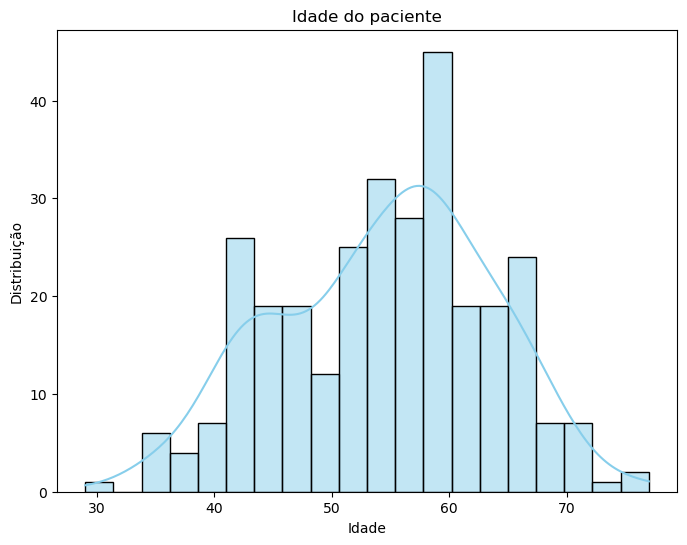

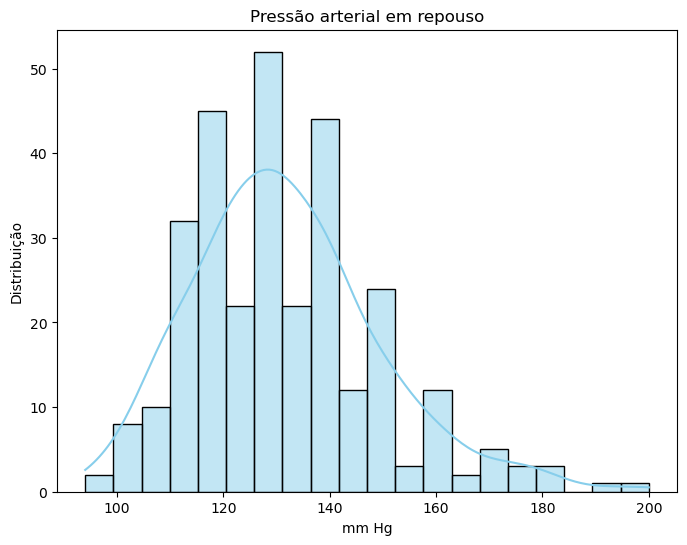

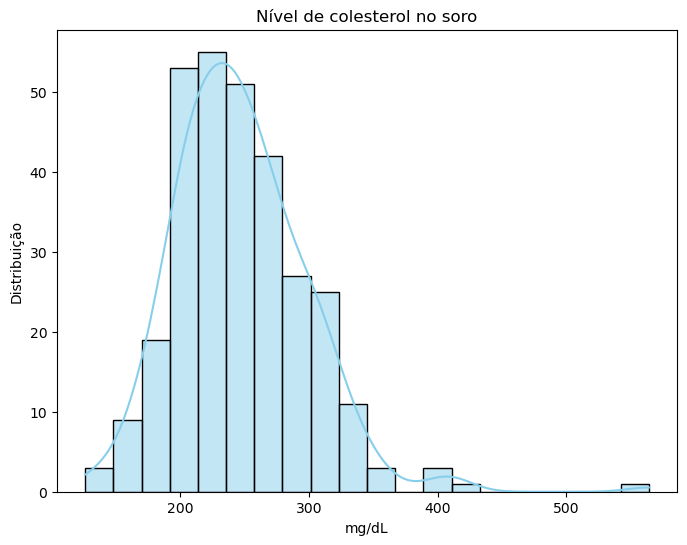

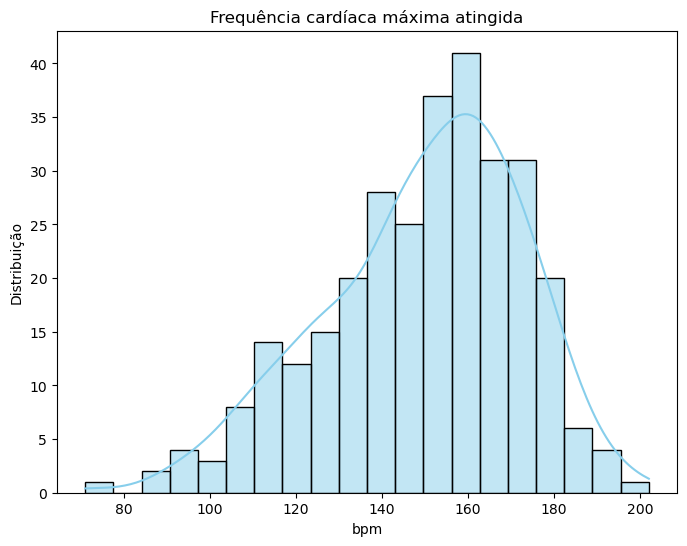

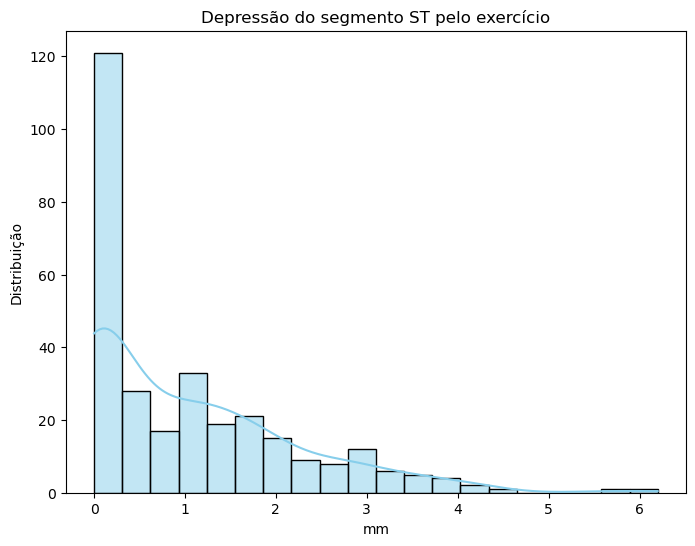

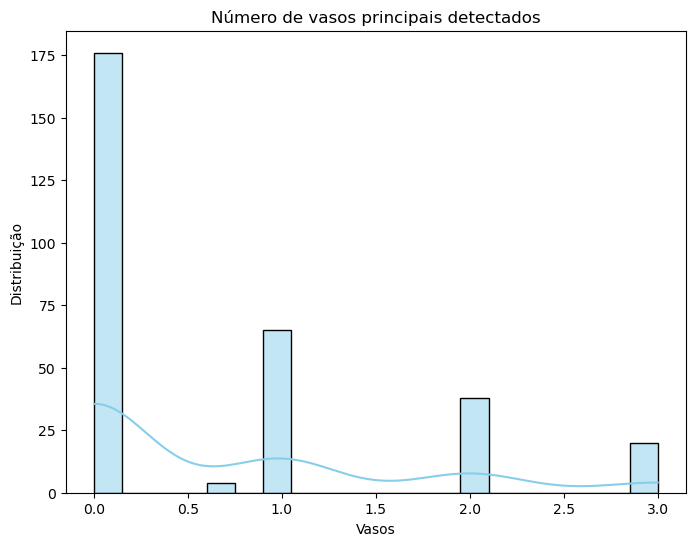

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

for index, row in Xnum_info.iterrows():
    
    plt.figure(figsize=(8, 6))
    sns.histplot(X[row["Var"]], kde=True, color='skyblue', bins=20)
    plt.title(row["Descrição"])
    if pd.isna(row["Unidade"]) or row["Unidade"] == "":
        plt.xlabel(row["Nome"])
    else:
        plt.xlabel(row["Unidade"])
    plt.ylabel('Distribuição')
    plt.show()

### Distribuição de Variáveis Qualitativas

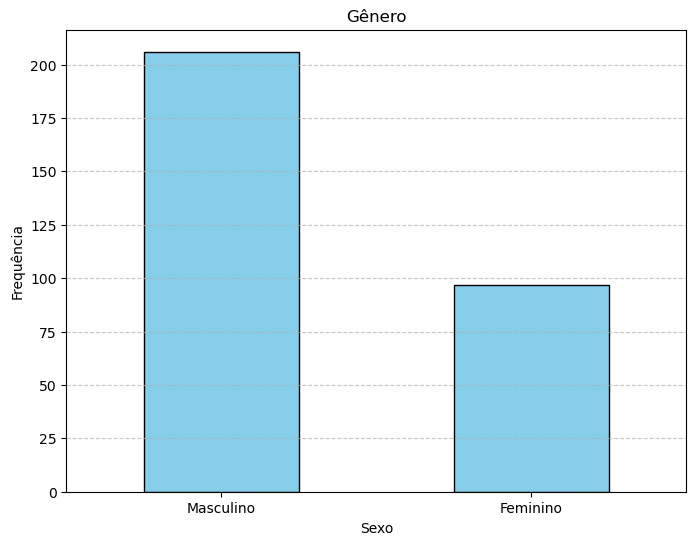

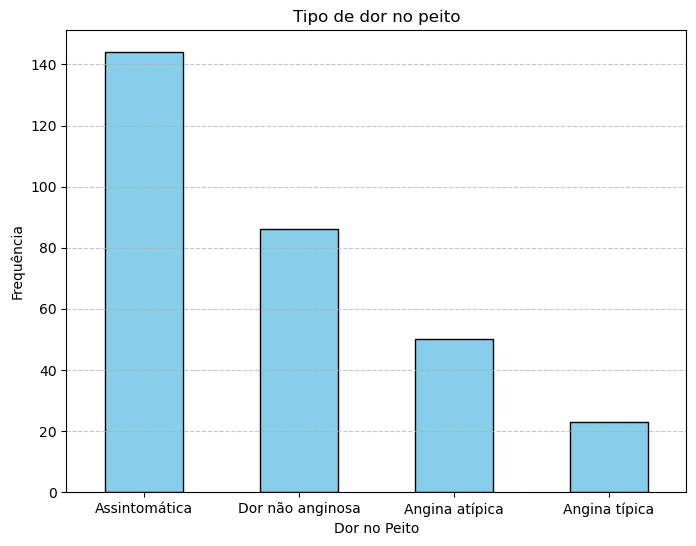

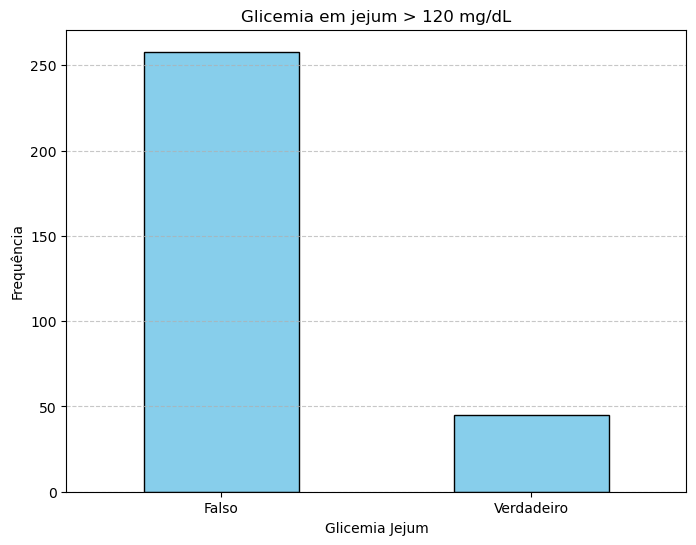

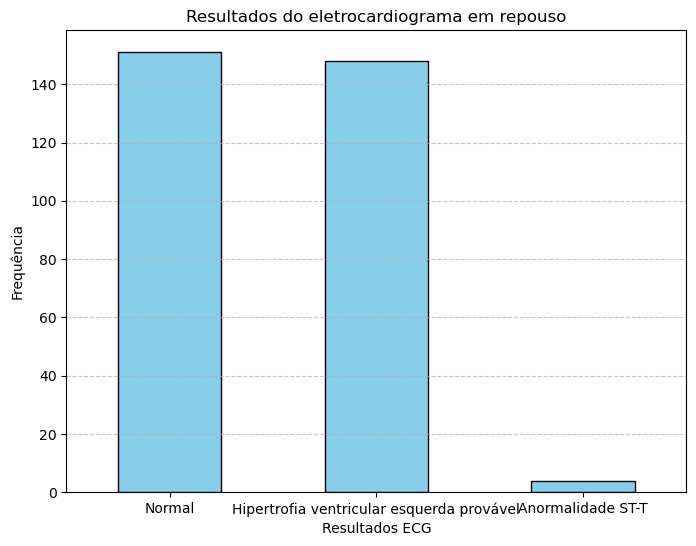

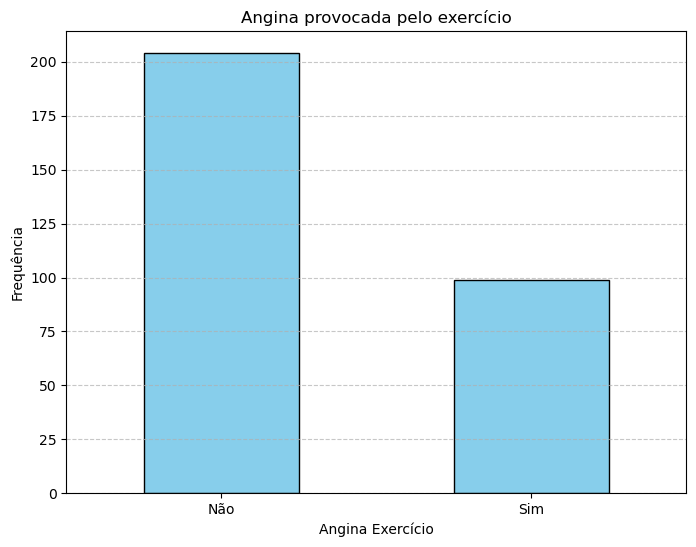

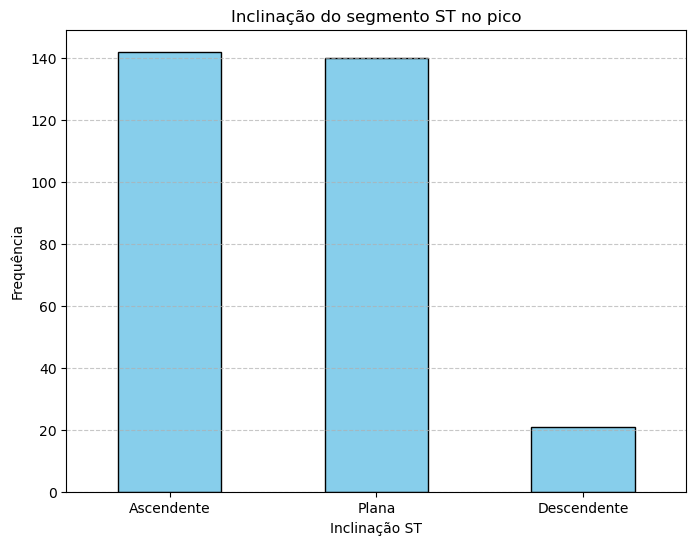

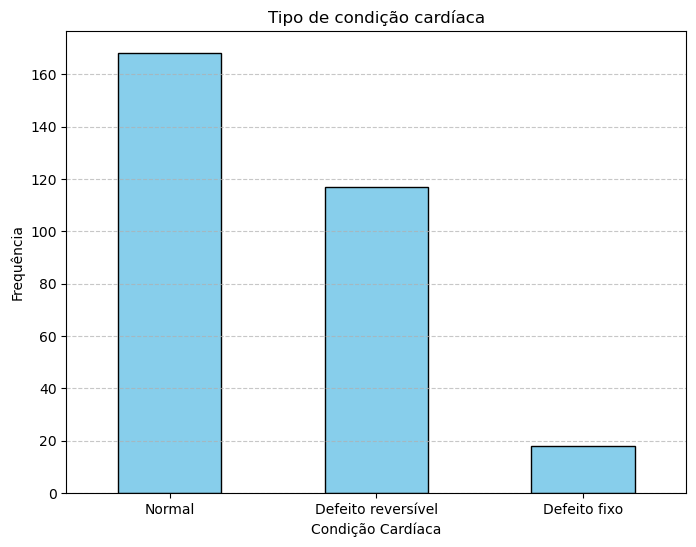

In [4]:
for index, row in Xcat_info.iterrows():
    # Variável Independente Categóricas
    plt.figure(figsize=(8, 6))
    
    counts = X[row["Var"]].map(row["Categorias"]).value_counts()
    
    # Barplot
    counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(row["Descrição"])
    plt.xlabel(row["Nome"])
    plt.ylabel("Frequência")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

### Distribuição Da Variável Dependente

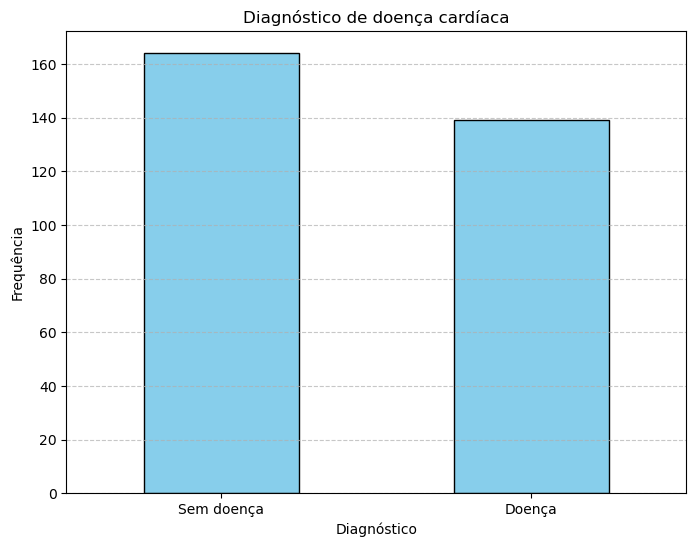

In [5]:
for index, row in y_info.iterrows():
    # Variável Dependente
    plt.figure(figsize=(8, 6))
    
    counts = y[row["Var"]].map(row["Categorias"]).value_counts()

    counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(row["Descrição"])
    plt.xlabel(row["Nome"])
    plt.ylabel("Frequência")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

## Associações

### Coeficiente de Contingência para Variáveis Qualitativas

Teste de coeficiente de contingência para variáveis qualitativas

A variável 'Sexo' tem uma FRACA Associação com o Diagnóstico (coef.: 0.270  <0.5).
A variável 'Dor no Peito' tem uma FORTE Associação com o Diagnóstico (coef.: 0.520  >0.5).
A variável 'Glicemia Jejum' tem uma FRACA Associação com o Diagnóstico (coef.: 0.016  <0.5).
A variável 'Resultados ECG' tem uma FRACA Associação com o Diagnóstico (coef.: 0.182  <0.5).
A variável 'Angina Exercício' tem uma FRACA Associação com o Diagnóstico (coef.: 0.425  <0.5).
A variável 'Inclinação ST' tem uma FRACA Associação com o Diagnóstico (coef.: 0.389  <0.5).
A variável 'Condição Cardíaca' tem uma FORTE Associação com o Diagnóstico (coef.: 0.522  >0.5).


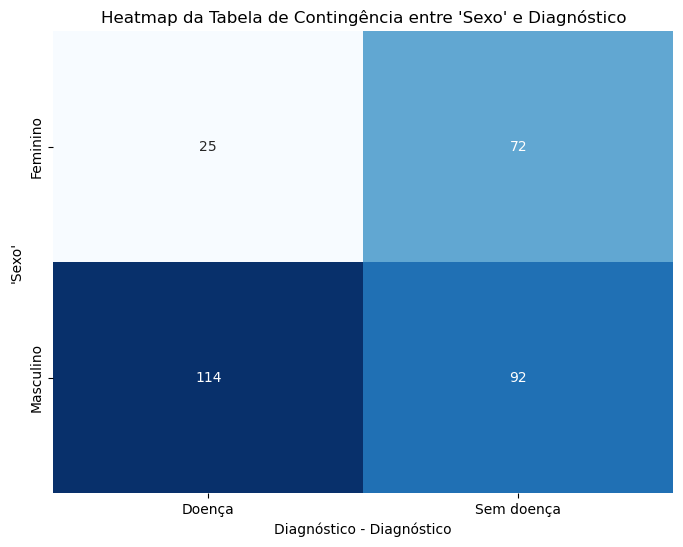

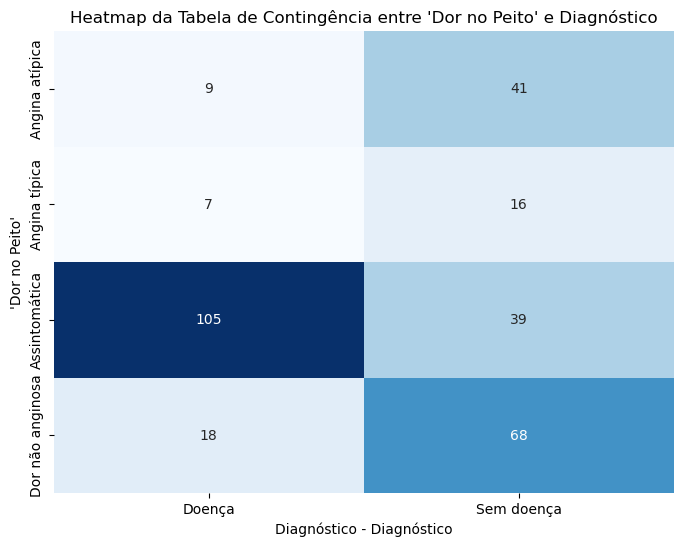

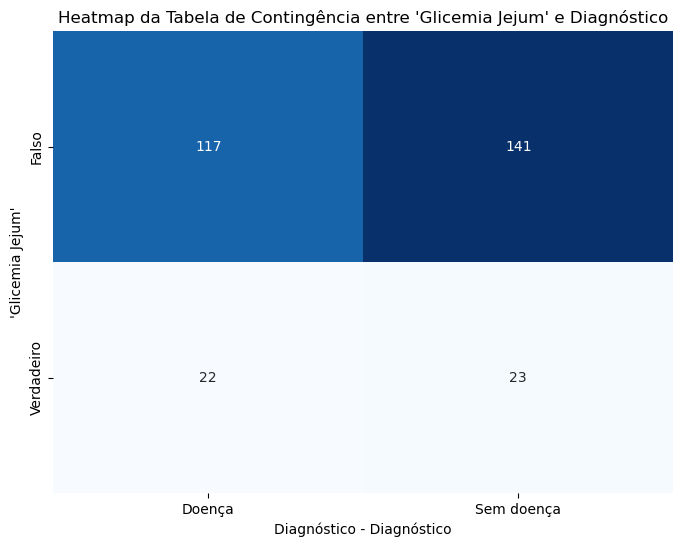

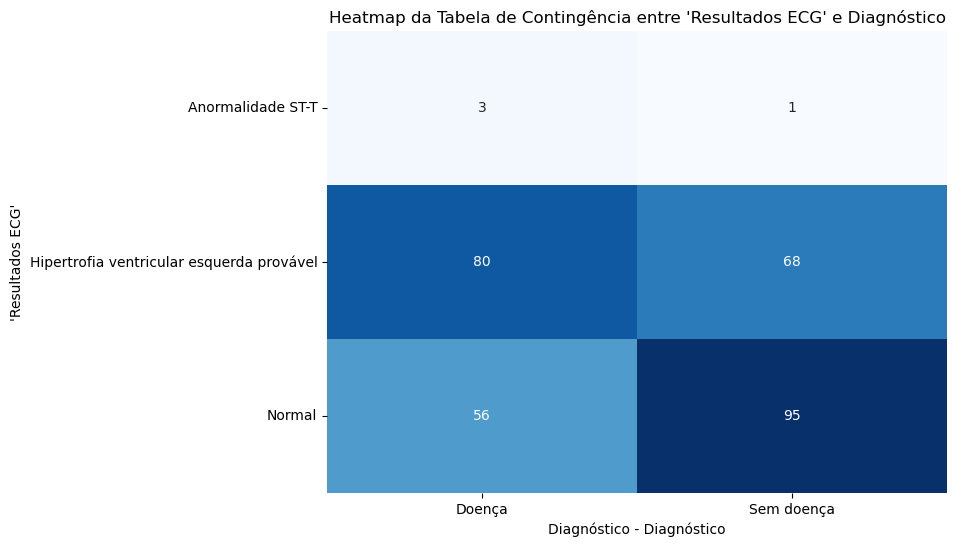

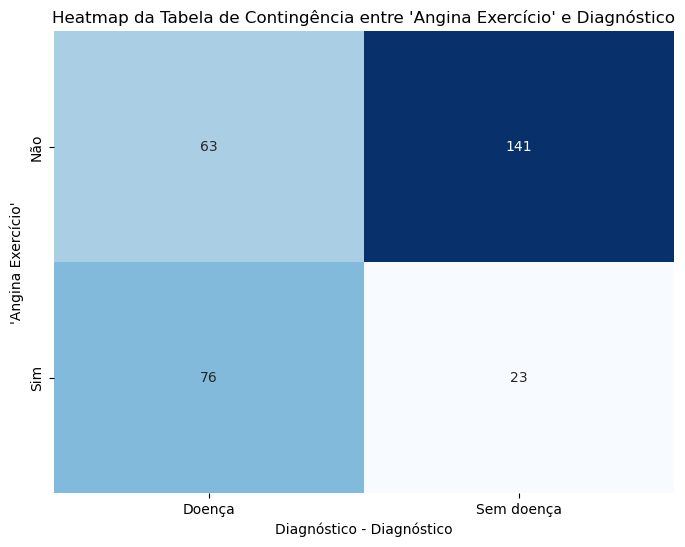

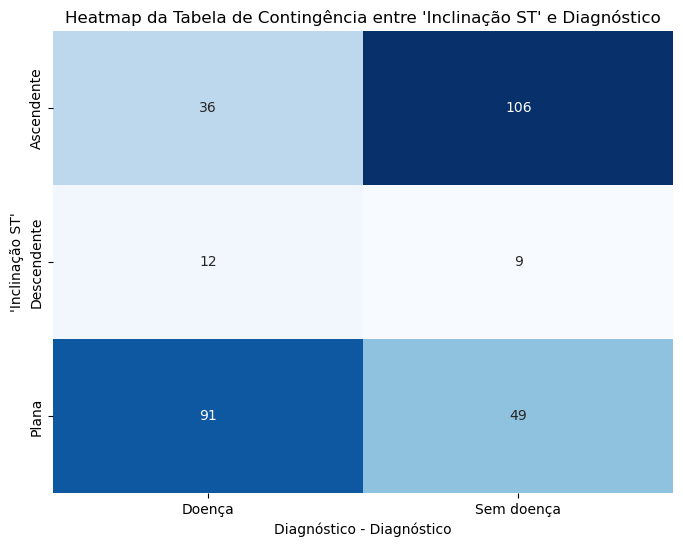

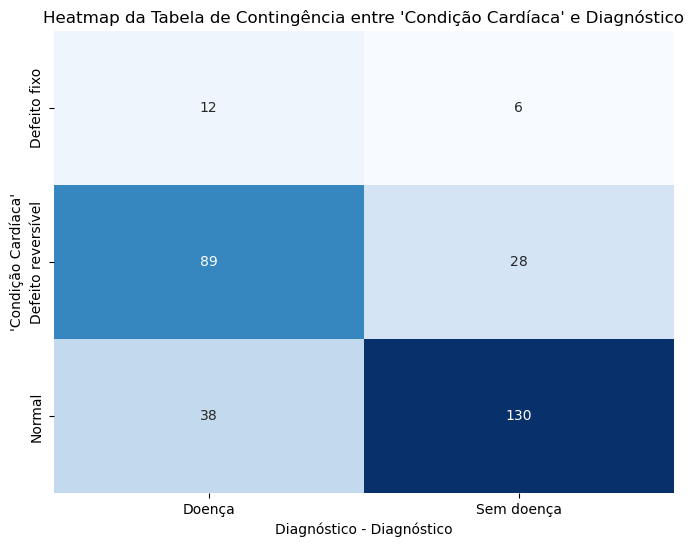

In [6]:
# slide 6
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def coeficiente_contingencia(X_cat, y):
    cont_table = pd.crosstab(X_cat, y)
    
    # teste qui-quadrado
    chi2, p, dof, expected = chi2_contingency(cont_table)
    
    # coef.cont. Cramér
    n = cont_table.sum().sum()  # n total de observações
    min_dim = min(cont_table.shape) - 1  # menor valor entre o número de linhas e colunas
    c_contingencia = np.sqrt(chi2 / (n * min_dim))
    
    return c_contingencia

coef_contingencia_results = {}
for var in Xcat_info['Var']:
    X_var = X[var]
    # coef. cont entre X_var e y["num"]
    coef_contingencia = coeficiente_contingencia(X_var, y["num"])
    
    # resultado
    coef_contingencia_results[var] = coef_contingencia


print("Teste de coeficiente de contingência para variáveis qualitativas\n")
for index, row in Xcat_info.iterrows():
    coef_con = coef_contingencia_results[row['Var']]
    if coef_con == 0:
        msg=["uma ausência de Associação", "=0"]
    elif coef_con == 1:
        msg=["uma perfeita Associação", "=1"]
    elif coef_con < 0.5:
        msg=["uma FRACA Associação", "<0.5"]
    else:
        msg=["uma FORTE Associação", ">0.5"]
    
    print(f"A variável '{row['Nome']}' tem {msg[0]} com o Diagnóstico (coef.: {coef_con:.3f}  {msg[1]}).")

# mapeamento de categorias
def map_categorias(values, categorias_dict):
    return values.map(categorias_dict)

# Heatmap da Tabela de Contingência
for _, row in Xcat_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # map dos valores numéricos para os nomes das categorias
    X_var_mapped = map_categorias(X_var, row['Categorias'])
    
    # map de y["num"] para os nomes das categorias
    y_mapped = map_categorias(y["num"], y_info.iloc[0]['Categorias'])
    
    # tabela de contingência
    cont_table = pd.crosstab(X_var_mapped, y_mapped)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cont_table, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title(f"Heatmap da Tabela de Contingência entre '{row['Nome']}' e {y_info.iloc[0]['Nome']}")
    plt.xlabel(f"{y_info.iloc[0]['Nome']} - Diagnóstico")
    plt.ylabel(f"'{row['Nome']}'")
    plt.show()

### Análise ANOVA para variáveis Quantitativas

A variável 'Idade' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


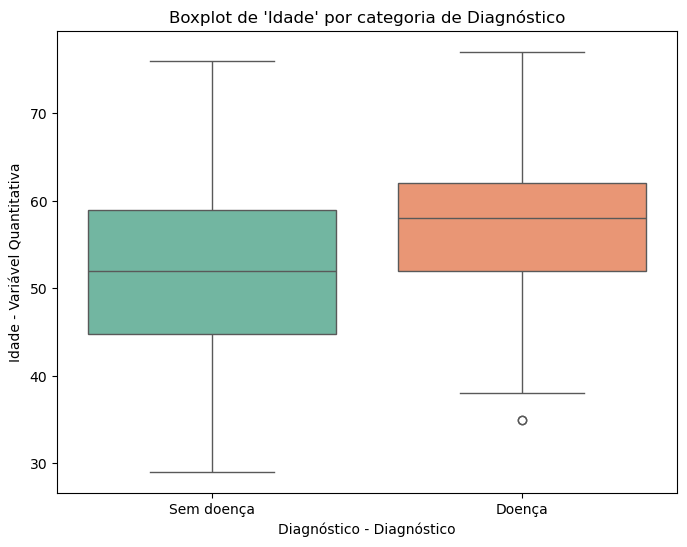

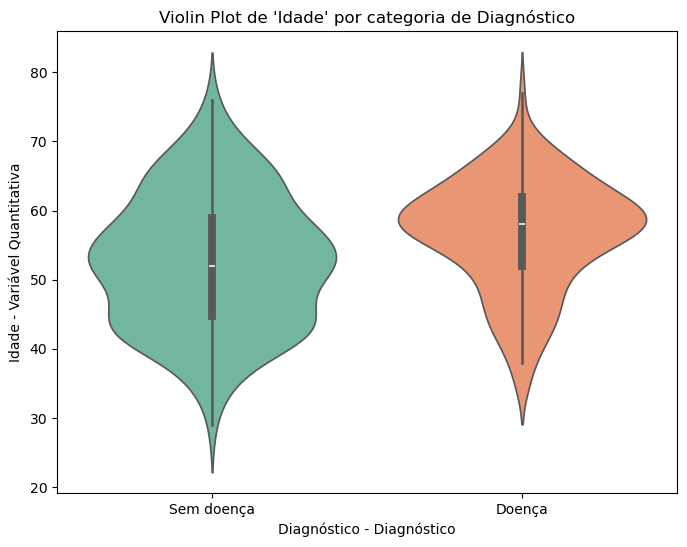

A variável 'PA em Repouso' tem uma diferença significativa entre o Diagnóstico (p-value: 0.009 < 0.05).


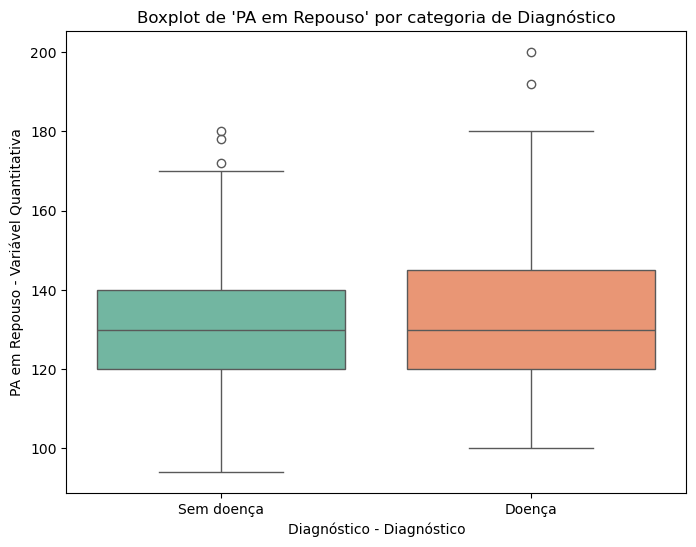

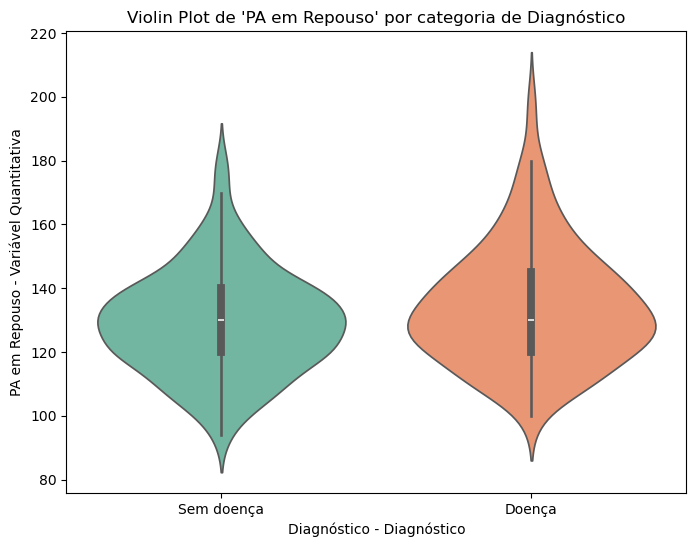

A variável 'Colesterol' NÃO tem uma diferença significativa entre o Diagnóstico (p-value: 0.139 > 0.05).


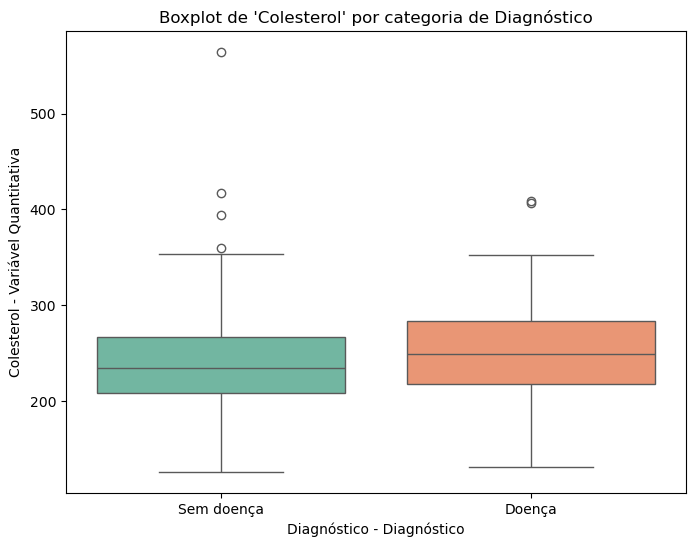

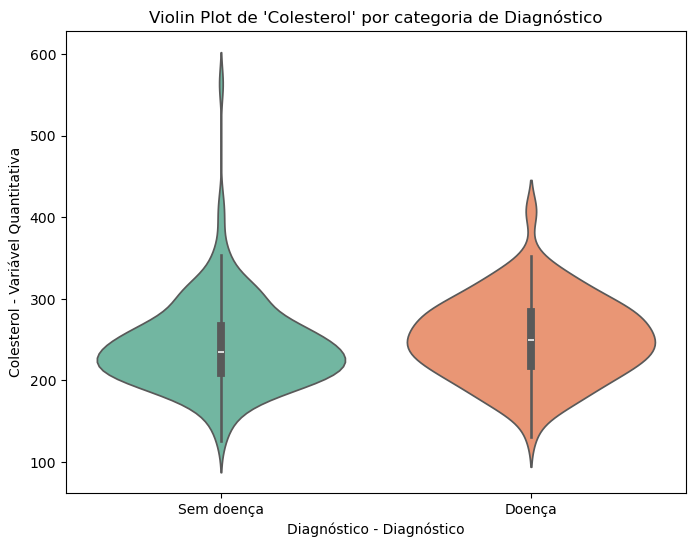

A variável 'FC Máxima' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


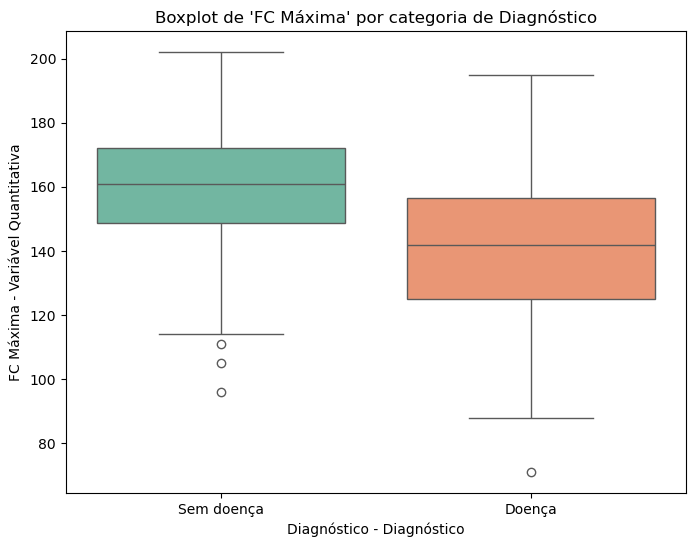

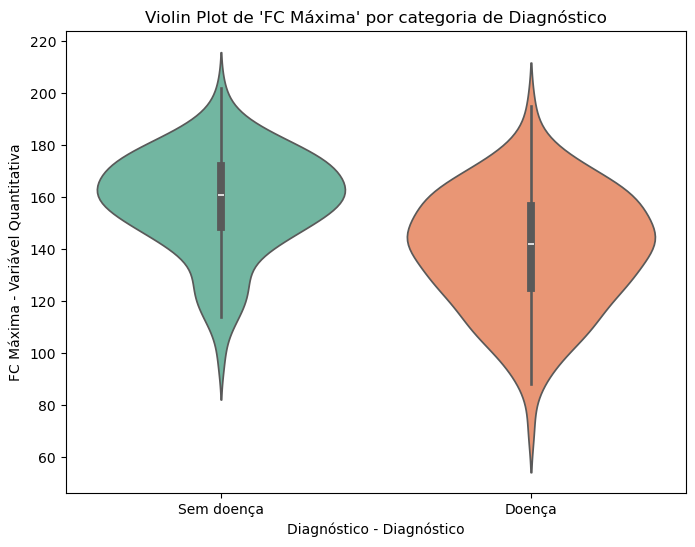

A variável 'Depressão ST' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


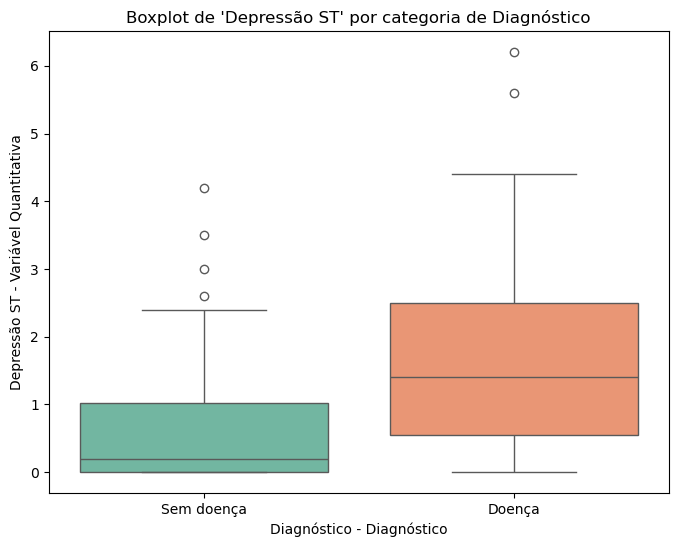

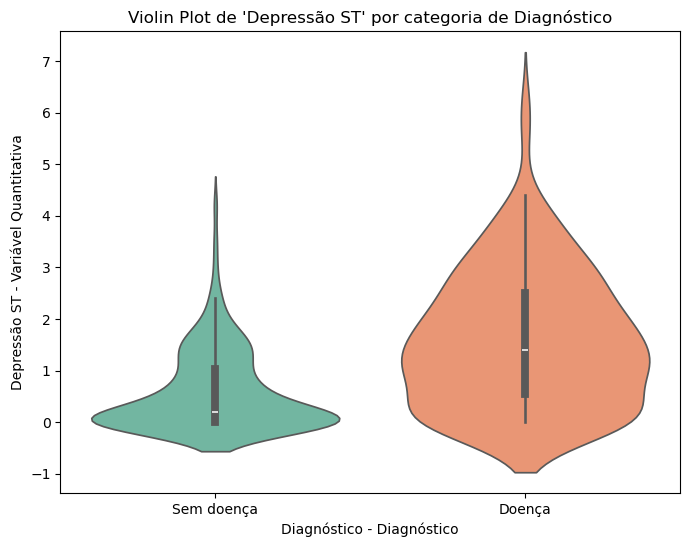

A variável 'Vasos' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


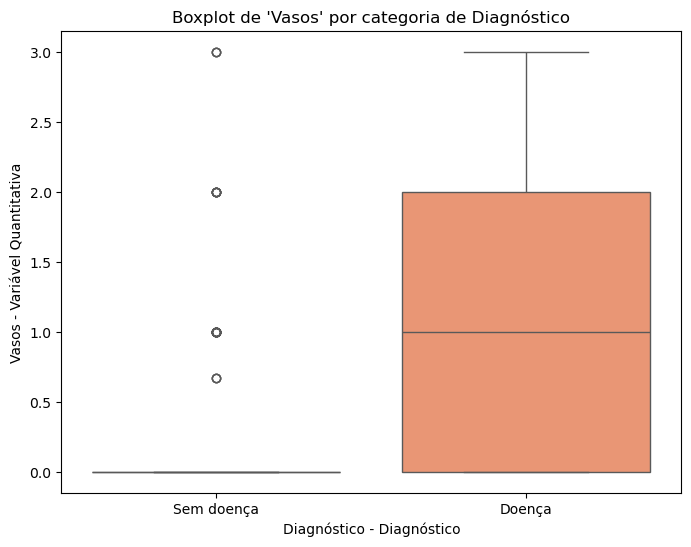

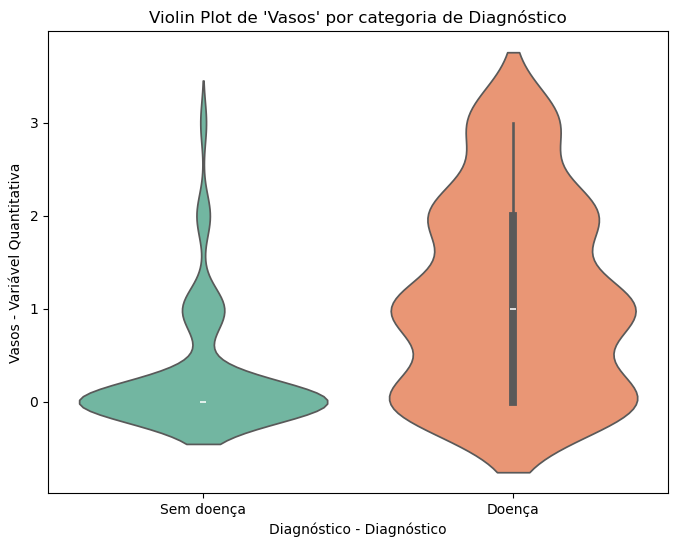

In [7]:
# slide 7
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

anova_results = {}

for var in Xnum_info['Var']: 
    X_var = X[var]
    
    # X_var pelas categorias de y["num"]
    groups = [X_var[y["num"] == category] for category in y["num"].unique()]
    
    # teste ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    anova_results[var] = (f_stat, p_value)

# plots
for _, row in Xnum_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # mapeio das categorias de y["num"]
    y_mapped = map_categorias(y["num"], y_info.iloc[0]['Categorias'])
    
    # dividir X_var pelas categorias de y["num"]
    groups = [X_var[y["num"] == category] for category in y_mapped.unique()]
    
    p_value = anova_results[row["Var"]][1]
    # exibir a mensagem sobre significância do p-value
    if p_value < 0.05:
        print(f"A variável '{row['Nome']}' tem uma diferença significativa entre o Diagnóstico (p-value: {p_value:.3f} < 0.05).")
    else:
        print(f"A variável '{row['Nome']}' NÃO tem uma diferença significativa entre o Diagnóstico (p-value: {p_value:.3f} > 0.05).")
    
    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y_mapped, y=X_var, hue=y_mapped, palette="Set2", legend=False)
    plt.title(f"Boxplot de '{row['Nome']}' por categoria de Diagnóstico")
    plt.xlabel(f"{y_info.iloc[0]['Nome']} - Diagnóstico")
    plt.ylabel(f"{row['Nome']} - Variável Quantitativa")
    plt.show()

    # Violin Plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=y_mapped, y=X_var, hue=y_mapped, palette="Set2", legend=False)
    plt.title(f"Violin Plot de '{row['Nome']}' por categoria de Diagnóstico")
    plt.xlabel(f"{y_info.iloc[0]['Nome']} - Diagnóstico")
    plt.ylabel(f"{row['Nome']} - Variável Quantitativa")
    plt.show()

## Correlação entre Variáveis Independentes e Variável Dependente
A variáveis independentes qualitativas dos dados de origem apresentam suas classes em um sistema numérico de inteiros, possibilitando o cálculo da correlação de todas as variáveis com a variável dependente.

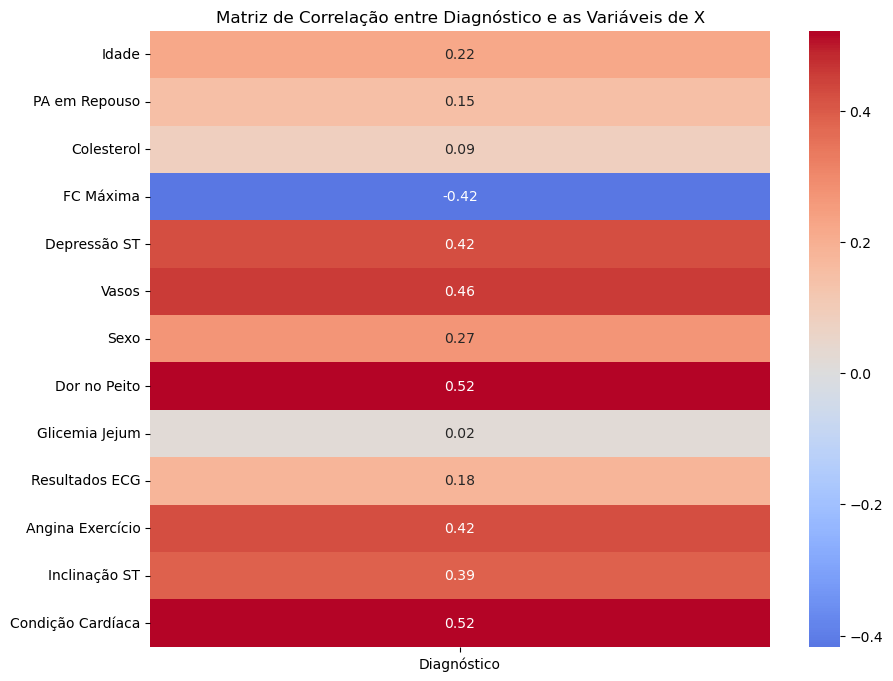

In [8]:
# slide 6 7
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# coef.cont Cramér novamente
def coeficiente_contingencia(X_cat, y):
    cont_table = pd.crosstab(X_cat, y)
    chi2, p, dof, expected = chi2_contingency(cont_table)
    n = cont_table.sum().sum()  # n total de observações
    min_dim = min(cont_table.shape) - 1  # menor valor entre o número de linhas e colunas
    c_contingencia = np.sqrt(chi2 / (n * min_dim))
    return c_contingencia

# correlações
correlation_results = {}

# correlação numéricas (Pearson)
for _, row in Xnum_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # correlação de Pearson com y["num"]
    correlation = X_var.corr(y["num"])
    correlation_results[row["Nome"]] = correlation

# coef. cont. para variáveis categóricas
for _, row in Xcat_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # coef. cont. com y["num"]
    c_contingencia = coeficiente_contingencia(X_var, y["num"])
    correlation_results[row["Nome"]] = c_contingencia

# matriz de correlação com os resultados
correlation_df = pd.DataFrame(correlation_results, index=[y_info.iloc[0]["Nome"]])

# Transpor a matriz (exibir em linhas)
correlation_df = correlation_df.T 

# Plotando o Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, center=0)
plt.title(f'Matriz de Correlação entre {y_info.iloc[0]["Nome"]} e as Variáveis de X')
plt.show()


## Modelos

### Regressão Logística

Relatório de Classificação:
              precision    recall  f1-score   support

  Sem doença       0.77      0.86      0.81        43
      Doença       0.86      0.77      0.81        48

    accuracy                           0.81        91
   macro avg       0.82      0.82      0.81        91
weighted avg       0.82      0.81      0.81        91

AUC-ROC: 0.896


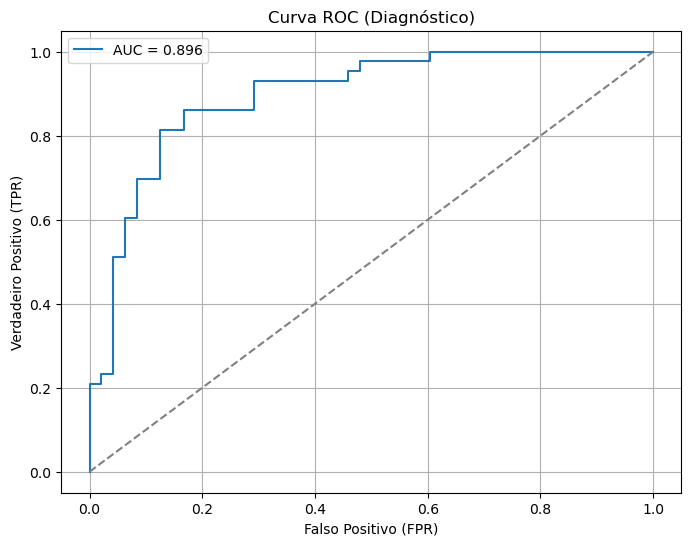

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# map de categorias y["num"]
y_category_map = y_info.iloc[0]['Categorias']
y_mapped = y["num"].map(y_category_map)

X_features = pd.concat([X[Xcat_info["Var"]], X[Xnum_info["Var"]]], axis=1)
y_target = y["num"]

cat_features = Xcat_info["Var"].tolist()
num_features = Xnum_info["Var"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

# preparação
# OneHot para categóricas, normalização para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)

# modelo de regressão logística
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# treino
logistic_model.fit(X_train, y_train)

# avaliação do modelo
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva

# mapeamento para predição
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_mapped = y_pred_series.map(y_category_map)
y_test_mapped = y_test.map(y_category_map)

print("Relatório de Classificação:")
print(classification_report(y_test_mapped, y_pred_mapped, target_names=list(y_category_map.values())))

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.3f}")

# curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f"Curva ROC ({y_info.iloc[0]['Nome']})")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.grid(True)
plt.show()


#### Análises da Regressão Logística

#### Métricas por Classe
##### Sem Doença
- **Precisão (precision)**: 0.77 – Das previsões classificadas como "Sem Doença", 77% estavam corretas.
- **Recall**: 0.86 – 86% das observações verdadeiramente "Sem Doença" foram corretamente identificadas.
- **F1-Score**: 0.81 – Indica um bom equilíbrio entre precisão e recall.
##### Com Doença
- **Precisão**: 0.86 – Das previsões classificadas como "Com Doença", 86% estavam corretas.
- **Recall**: 0.77 – 77% das observações verdadeiramente "Com Doença" foram corretamente identificadas.
- **F1-Score**: 0.81 – Equilíbrio similar ao observado para a classe "Sem Doença".

#### Métricas Gerais
   - **Acurácia (accuracy)**: 0.81 – O modelo está correto em 81% dos casos.
   - **Macro Average**: 0.82 para precisão e recall – Indica que as classes estão sendo tratadas de maneira equilibrada pelo modelo.
   - **Weighted Average**: 0.81 – Pondera as métricas com base no número de observações em cada classe, sendo igual à acurácia devido ao balanceamento dos dados.

#### AUC-ROC (Área Sob a Curva ROC)
Este modelo possui bom desempenho discriminativo, com alta probabilidade de classificar corretamente uma observação "Com Doença" versus "Sem Doença".

**Valor**: 0.896 – Representa a capacidade do modelo em diferenciar entre as classes. Obtivemos um valor próximo de 1 demonstrando uma boa capacidade de classificação.


#### Observações e Insights

- O modelo tem desempenho equilibrado entre as duas classes, com boas métricas de precisão, recall e F1-score.
- Observou-se um pequeno desequilíbrio entre as classes em recall (86% vs. 77%), onde o modelo obteve um precisão mais alta na classe "Doença".
- A alta AUC-ROC (0.896) reforça a confiança no modelo, especialmente para aplicações onde é crucial diferenciar corretamente as classes.

### Árvore de Decisão

Relatório de Classificação (Árvore de Decisão):
              precision    recall  f1-score   support

  Sem doença       0.78      0.72      0.75        43
      Doença       0.76      0.81      0.79        48

    accuracy                           0.77        91
   macro avg       0.77      0.77      0.77        91
weighted avg       0.77      0.77      0.77        91

AUC-ROC (Árvore de Decisão): 0.753


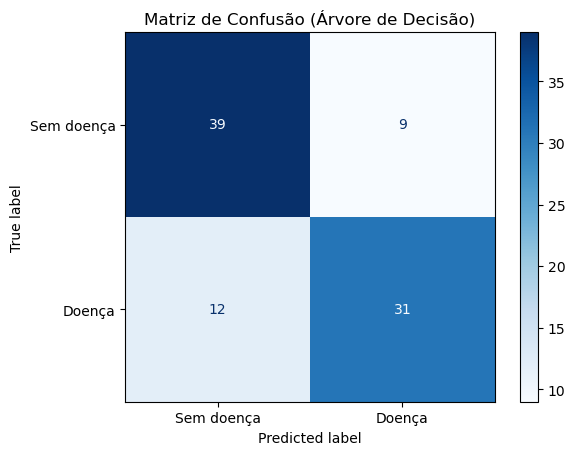

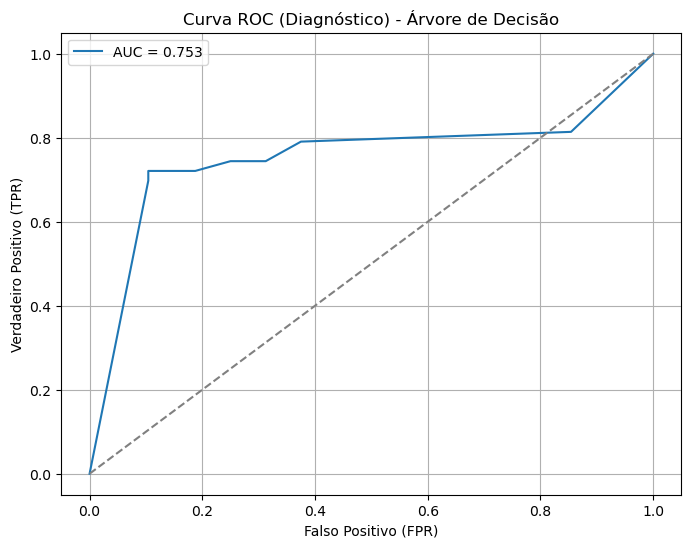

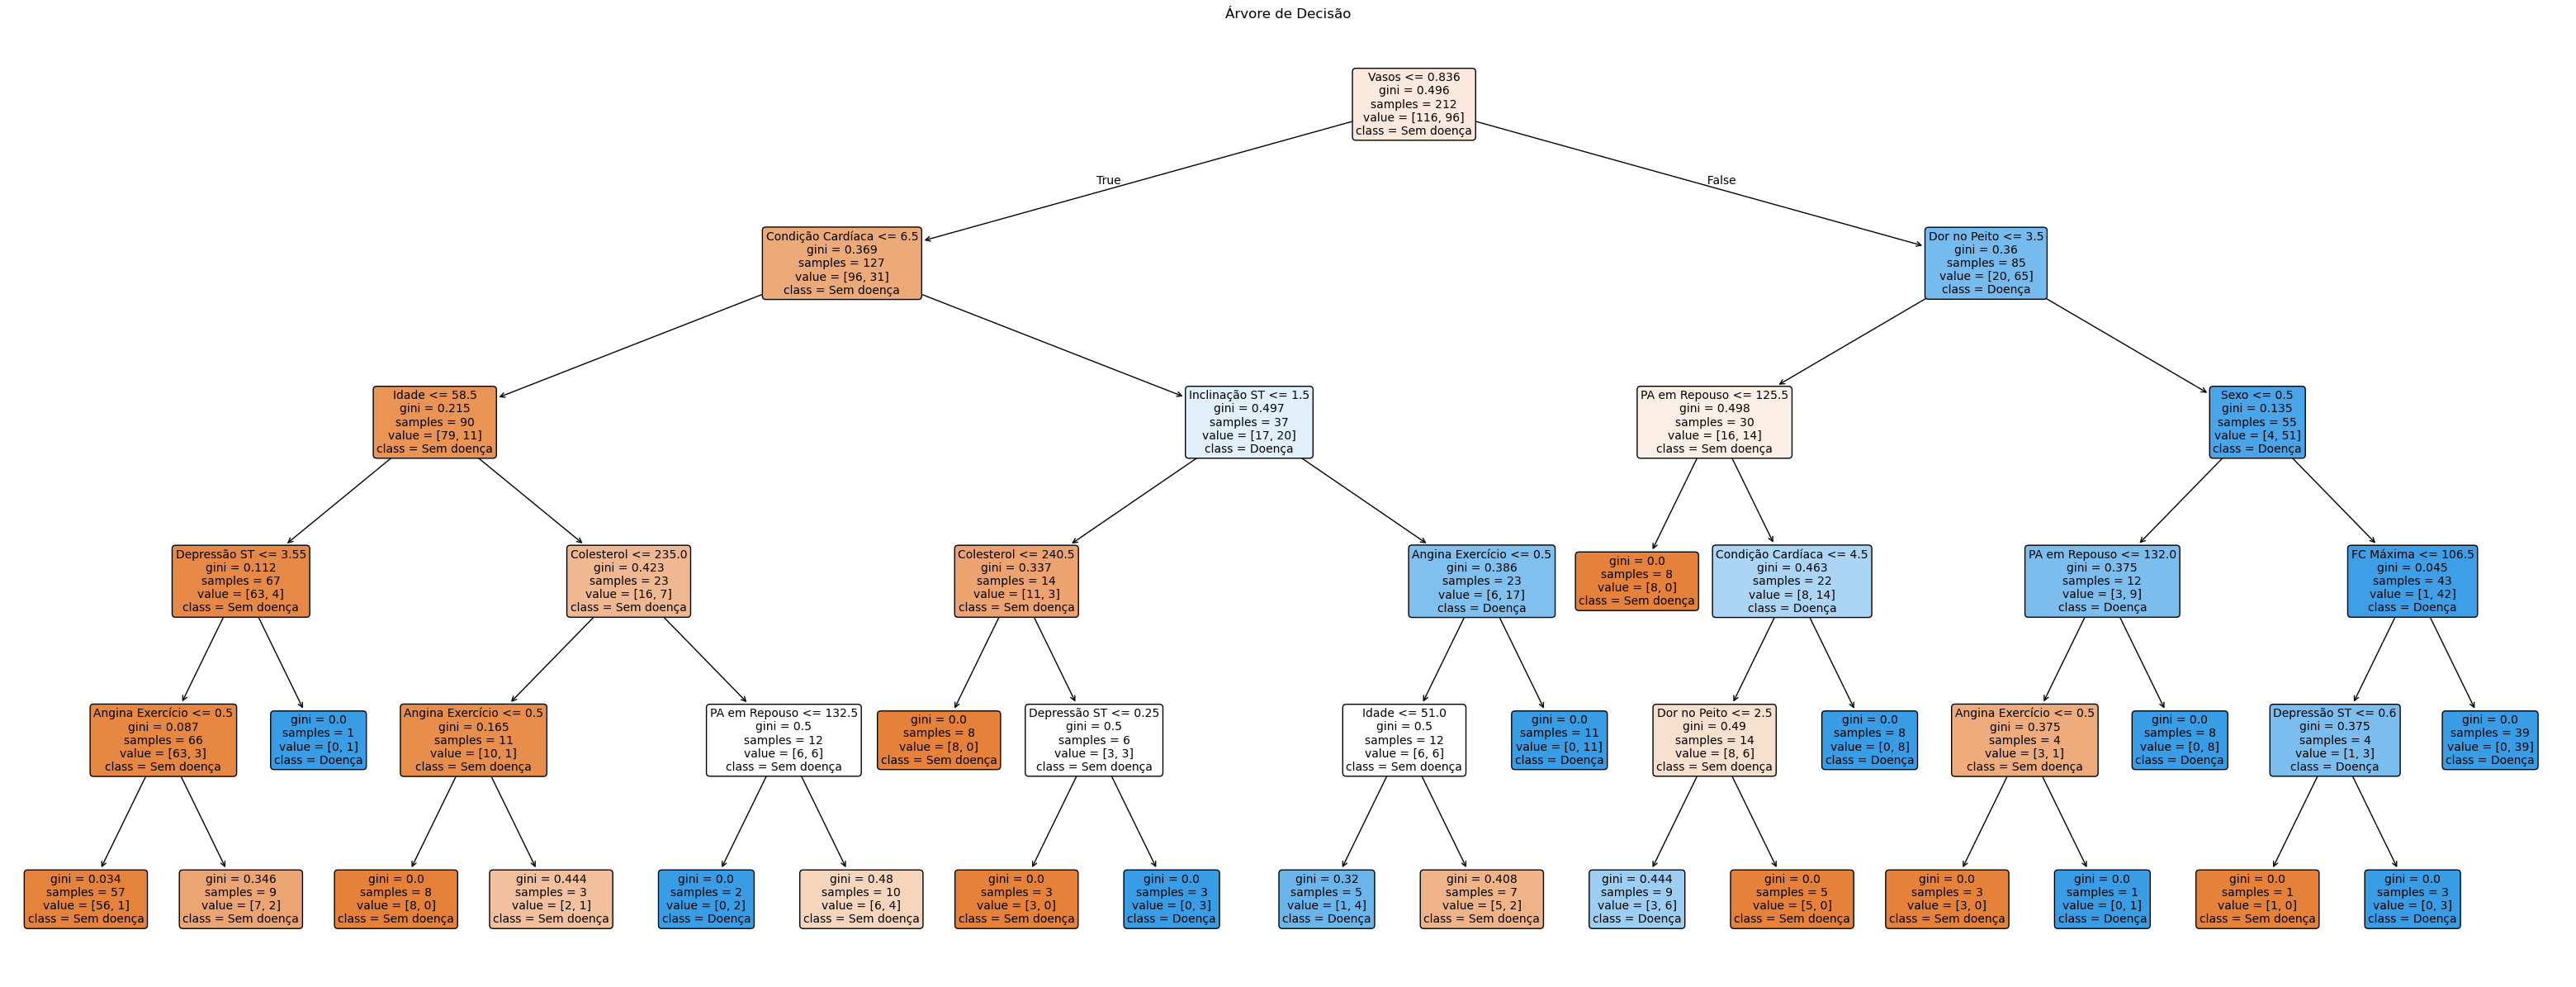

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import export_text

X_features = pd.concat([X[Xcat_info["Var"]], X[Xnum_info["Var"]]], axis=1)
y_target = y["num"]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

# modelo de árvore de decisão
decision_tree_model = DecisionTreeClassifier(random_state=42, max_depth=5, criterion='gini')

# treino do modelo com os dados de treino
decision_tree_model.fit(X_train, y_train)

# predição com os dados de teste
y_pred_tree = decision_tree_model.predict(X_test)
y_pred_proba_tree = decision_tree_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# mapeamento de categorias para os valores previstos e reais
y_pred_tree_series = pd.Series(y_pred_tree, index=y_test.index)
y_pred_tree_mapped = y_pred_tree_series.map(y_category_map)
y_test_tree_mapped = y_test.map(y_category_map)

print("Relatório de Classificação (Árvore de Decisão):")
print(classification_report(y_test_tree_mapped, y_pred_tree_mapped, target_names=list(y_category_map.values())))

# AUC-ROC
auc_roc_tree = roc_auc_score(y_test, y_pred_proba_tree)
print(f"AUC-ROC (Árvore de Decisão): {auc_roc_tree:.3f}")

cm_tree = confusion_matrix(y_test_tree_mapped, y_pred_tree_mapped, labels=list(y_category_map.values()))
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=list(y_category_map.values()))
disp_tree.plot(cmap="Blues")
plt.title("Matriz de Confusão (Árvore de Decisão)")
plt.show()

# Curva ROC
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_proba_tree)
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f'AUC = {auc_roc_tree:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f"Curva ROC ({y_info.iloc[0]['Nome']}) - Árvore de Decisão")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.grid(True)
plt.show()


# nomes em português
cat_names = Xcat_info["Nome"].tolist()
num_names = Xnum_info["Nome"].tolist()
feature_names = cat_names + num_names 

# a árvore de decisão em formato de texto
#tree_rules = export_text(decision_tree_model, feature_names=feature_names)
#print("Árvore de Decisão (em formato de texto):")
#print(tree_rules)

plt.figure(figsize=(40, 15))
plot_tree(
    decision_tree_model,
    feature_names=feature_names,
    class_names=list(y_category_map.values()),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Árvore de Decisão")
plt.show()

#### Análises da Arvore de Decisão

#### Relatório de Classificação
O relatório de classificação resume a performance do modelo para cada classe, destacando as métricas como precisão (precision), recall e f1-score.

O modelo obteve uma **precisão e recall equilibrados** para ambas as classes ("Sem doença" e "Doença"), com uma **acurácia de 77%**. Isso indica um bom desempenho na tarefa de classificação.

#### AUC-ROC (Área sob a Curva ROC)
**AUC-ROC** de **0.753** próximo a 1, demostra uma boa capacidade do modelo para discriminação entre as duas classes ("Sem doença" e "Doença").

#### Regras de decisão
A árvore de decisão forneceu uma visão detalhada das regras de decisão que o modelo usou para classificar as instâncias. Essas regras podem ser usadas para auxílio na identificação de pacientes com maior ou menor risco de desenvolver a condição, oferecendo insights valiosos para o diagnóstico e acompanhamento clínico.

##### **Variáveis Mais Influentes**
A árvore inicia com a variável **Vasos**. Esta variável é usada para dividir o conjunto de dados em dois grupos distintos, sendo uma das variáveis mais importantes na predição.

- **Vasos ≤ 0.84**: Divide o conjunto em duas grandes partes e é uma das primeiras a ser utilizada, mostrando que há uma grande distinção entre pacientes com valores abaixo e acima desse limite.
- **Condição Cardíaca**: Essa variável aparece várias vezes na árvore, tanto para pacientes com valores de **Vasos ≤ 0.84** quanto **Vasos > 0.84**, destacando-se como uma característica importante na decisão sobre a presença ou ausência da condição.
- **Idade**: A variável "Idade" também é frequentemente usada para dividir os dados, especialmente entre **Idade ≤ 58.5** ou **Idade > 58.5**, o que sugere que a faixa etária é um fator relevante no diagnóstico.
- **PA em Repouso** (Pressão Arterial em Repouso): Aparece em diferentes divisões da árvore, especialmente em relação aos valores maiores e menores de 125.50 e 132.00, evidenciando sua relevância na classificação.

##### **Fatores Importantes para a Presença de Doença**
A árvore demonstra que a doença é fortemente associada a várias condições. Sendo as mais determinantes:
- **Vasos > 0.84**: Quando a variável "Vasos" está acima desse valor, a probabilidade de a pessoa ser diagnosticada com a doença aumenta consideravelmente, especialmente com valores de **PA em Repouso** maiores (acima de 125.50) ou **Condição Cardíaca > 4.50**.
- **Dor no Peito > 3.50**: Isso indica uma associação direta entre a dor no peito mais intensa e a presença de doença, especialmente se combinado com características como o **Sexo** e a **FC Máxima**.
- **Condição Cardíaca > 4.50**: Para casos com **Vasos > 0.84**, valores elevados da **Condição Cardíaca** também são um forte indicador de presença de doença.

##### **Fatores Importantes para a Ausência de Doença**
A ausência da doença é mais prevalente nas condições:
- **Vasos ≤ 0.84**: Esse grupo tende a ser associado à ausência de doença, com variáveis como **Idade ≤ 58.5** e **Angina Exercício ≤ 0.50** ajudando a separar aqueles sem a condição.
- **Angina Exercício ≤ 0.50**: Quando a intensidade de angina (dor no peito ao exercício) é baixa, a probabilidade de não ter a doença aumenta.
- **Pressão Arterial em Repouso ≤ 125.50**: Para aqueles com **Dor no Peito ≤ 3.50**, uma pressão arterial em repouso mais baixa também está associada à ausência de doença.

### Random Forest

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

  Sem doença       0.86      0.84      0.85        43
      Doença       0.86      0.88      0.87        48

    accuracy                           0.86        91
   macro avg       0.86      0.86      0.86        91
weighted avg       0.86      0.86      0.86        91

AUC-ROC (Random Forest): 0.921


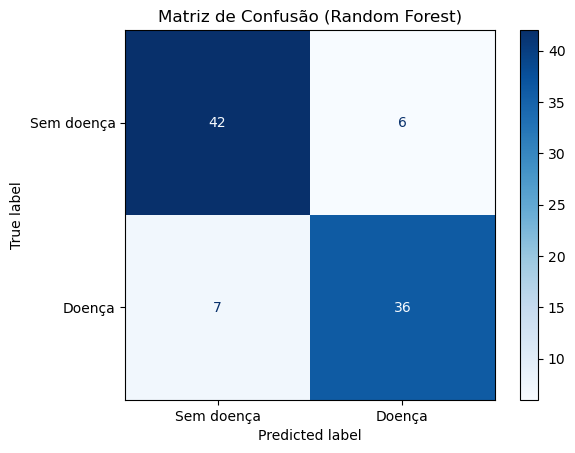

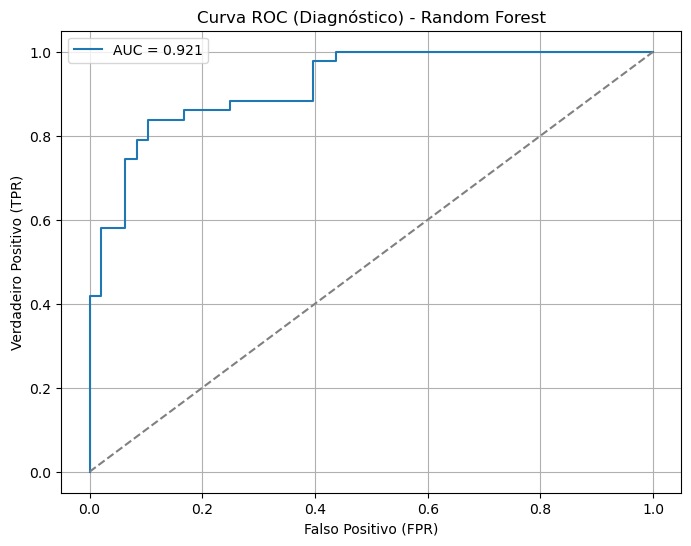

Importância das variáveis na Random Forest:
              Feature  Importance
1        Dor no Peito    0.148639
6   Condição Cardíaca    0.147152
12              Vasos    0.139328
10          FC Máxima    0.103789
11       Depressão ST    0.085145
7               Idade    0.077127
4    Angina Exercício    0.066850
9          Colesterol    0.066349
8       PA em Repouso    0.058019
0                Sexo    0.048548
5       Inclinação ST    0.038153
3      Resultados ECG    0.013143
2      Glicemia Jejum    0.007758


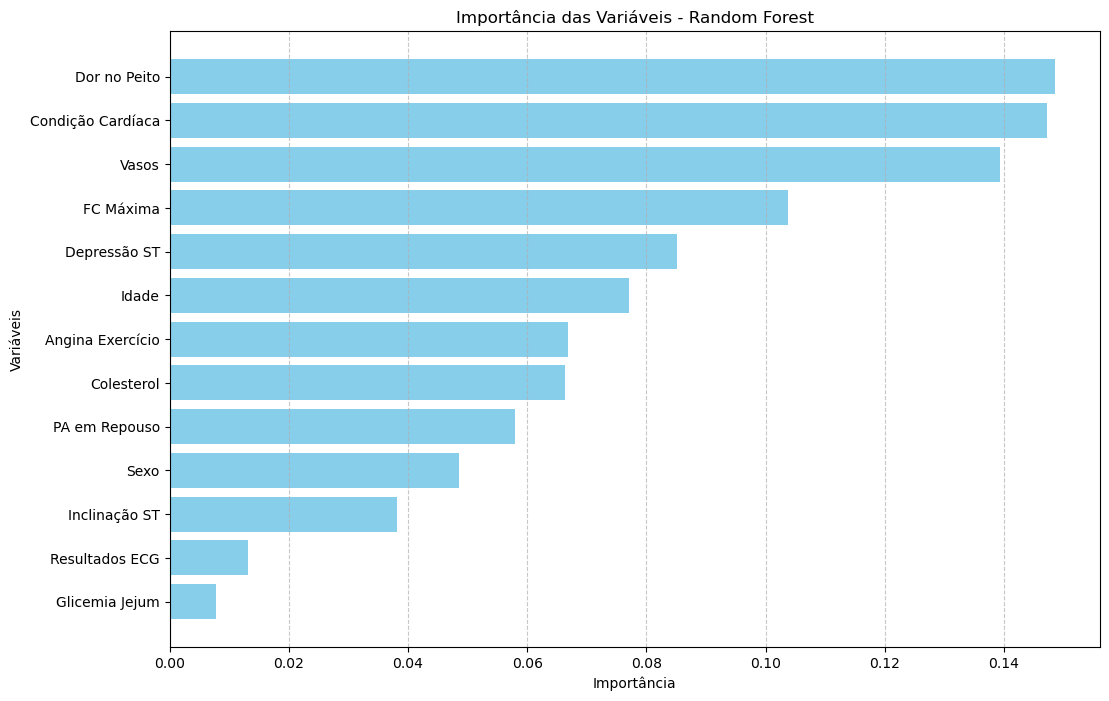

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

X_features = pd.concat([X[Xcat_info["Var"]], X[Xnum_info["Var"]]], axis=1)
y_target = y["num"]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

# modelo Random Forest
random_forest_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,   # número de árvores na floresta
    max_depth=5,        # profundidade máxima das árvores
    criterion='gini',   # critério para divisão 
    n_jobs=-1           # todos os núcleos disponíveis para acelerar
)

# treino
random_forest_model.fit(X_train, y_train)

# predição
y_pred_rf = random_forest_model.predict(X_test)
y_pred_proba_rf = random_forest_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# mapeamento de categorias para os valores previstos e reais
y_pred_rf_series = pd.Series(y_pred_rf, index=y_test.index)
y_pred_rf_mapped = y_pred_rf_series.map(y_category_map)
y_test_rf_mapped = y_test.map(y_category_map)

print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test_rf_mapped, y_pred_rf_mapped, target_names=list(y_category_map.values())))

# AUC-ROC
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC (Random Forest): {auc_roc_rf:.3f}")

cm_rf = confusion_matrix(y_test_rf_mapped, y_pred_rf_mapped, labels=list(y_category_map.values()))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=list(y_category_map.values()))
disp_rf.plot(cmap="Blues")
plt.title("Matriz de Confusão (Random Forest)")
plt.show()

# Curva ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_roc_rf:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f"Curva ROC ({y_info.iloc[0]['Nome']}) - Random Forest")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.grid(True)
plt.show()

# importância das variáveis
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': random_forest_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# variáveis mais importantes
print("Importância das variáveis na Random Forest:")
print(feature_importances)


plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Os resultados obtidos do modelo Random Forest apresentam um desempenho sólido, possibilitando a extração de outro conjunto de insights sobre os dados. É observado a constância em influência variáveis como 'Dor no Peito' e 'Condição Cardiaca' no presente modelo e nos anteriores. 

#### Desempenho do Modelo
##### Métricas de Classificação
**Precisão (Precision)**
 - Para a classe "Sem doença", a precisão de 0.86 indica que 86% das previsões positivas foram realmente corretas.
 - Para a classe "Doença", a precisão também foi de 0.86, sugerindo que o modelo está equilibrado ao identificar ambas as classes.

**Recall**:
 - A classe "Sem doença" teve um recall de 0.84, significando que 84% dos casos reais de "Sem doença" foram corretamente identificados.
 - Para a classe "Doença", o recall foi 0.88, ou seja, o modelo teve um bom desempenho ao capturar casos de "Doença".

**F1-Score**:
- O F1-score (média harmônica entre precisão e recall) é 0.85 e 0.87 para "Sem doença" e "Doença", respectivamente, indicando um bom equilíbrio entre essas métricas.

##### Acurácia Geral
O modelo atingiu uma acurácia geral de **86%**, o que é adequado, considerando o problema.

##### AUC-ROC
O valor de **AUC-ROC = 0.921** demonstra que o modelo tem um excelente poder discriminativo, pois está próximo de 1. Isso significa que ele consegue distinguir bem entre os casos de "Sem doença" e "Doença".

#### Importância das Variáveis
As variáveis mais relevantes para as decisões do modelo foram:
1. **Dor no Peito (14.86%)**
2. **Condição Cardíaca (14.71%)**
3. **Vasos Coronários Visíveis (13.93%)**
4. **Frequência Cardíaca Máxima (10.37%)** e **Depressão ST (8.51%)**

As variáveis com menor influência, são **Resultados de ECG (1.31%)** e **Glicemia em Jejum (0.78%)**.


### Naive Bayes

Relatório de Classificação (Naive Bayes):
              precision    recall  f1-score   support

  Sem doença       0.78      0.81      0.80        43
      Doença       0.83      0.79      0.81        48

    accuracy                           0.80        91
   macro avg       0.80      0.80      0.80        91
weighted avg       0.80      0.80      0.80        91

AUC-ROC (Naive Bayes): 0.881


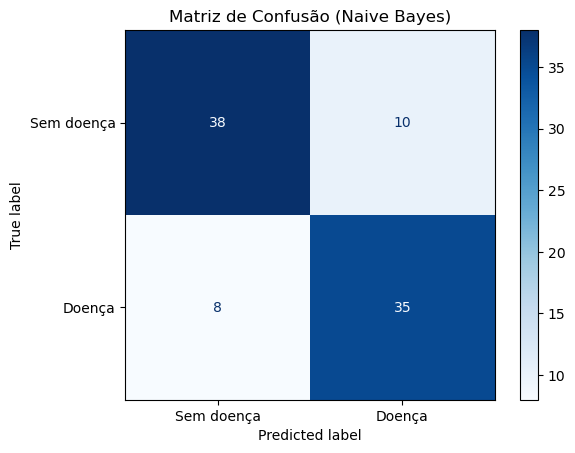

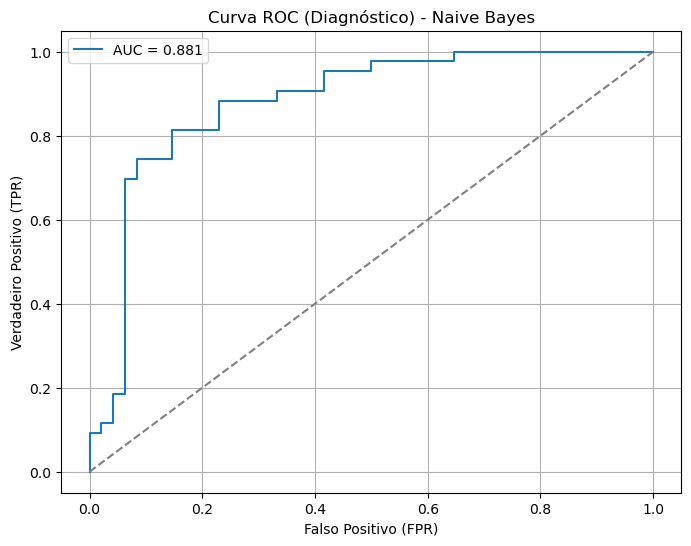

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Naive Bayes
naive_bayes_model = GaussianNB()

# treino
naive_bayes_model.fit(X_train, y_train)

# predição
y_pred_nb = naive_bayes_model.predict(X_test)
y_pred_proba_nb = naive_bayes_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# mapeamento para os valores previstos e reais
y_pred_nb_series = pd.Series(y_pred_nb, index=y_test.index)
y_pred_nb_mapped = y_pred_nb_series.map(y_category_map)
y_test_nb_mapped = y_test.map(y_category_map)

print("Relatório de Classificação (Naive Bayes):")
print(classification_report(y_test_nb_mapped, y_pred_nb_mapped, target_names=list(y_category_map.values())))

# AUC-ROC
auc_roc_nb = roc_auc_score(y_test, y_pred_proba_nb)
print(f"AUC-ROC (Naive Bayes): {auc_roc_nb:.3f}")

cm_nb = confusion_matrix(y_test_nb_mapped, y_pred_nb_mapped, labels=list(y_category_map.values()))
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=list(y_category_map.values()))
disp_nb.plot(cmap="Blues")
plt.title("Matriz de Confusão (Naive Bayes)")
plt.show()

# Curva ROC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_proba_nb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {auc_roc_nb:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f"Curva ROC ({y_info.iloc[0]['Nome']}) - Naive Bayes")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.grid(True)
plt.show()


### Neural Networks

Relatório de Classificação (Rede Neural):
              precision    recall  f1-score   support

  Sem doença       0.65      0.79      0.72        43
      Doença       0.77      0.62      0.69        48

    accuracy                           0.70        91
   macro avg       0.71      0.71      0.70        91
weighted avg       0.71      0.70      0.70        91

AUC-ROC (Rede Neural): 0.833


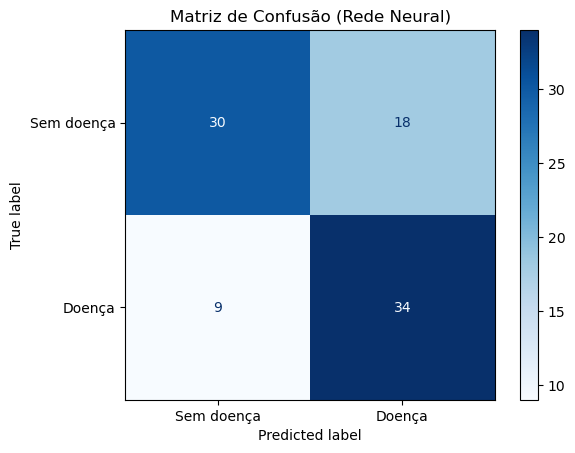

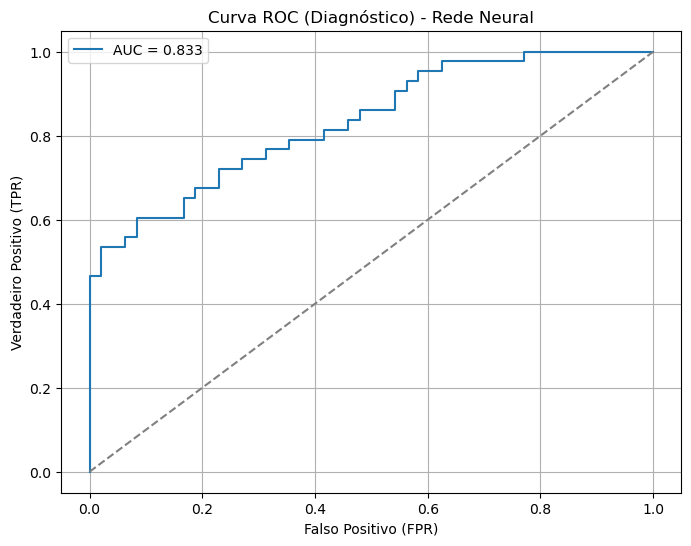

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Rede Neural (MLP)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50, 30),  # neurônios nas camadas ocultas
    activation='relu',            # ativação
    solver='adam',                # algoritmo de otimização
    max_iter=1000,                # número máximo de iterações
    random_state=42,              # seed aleatória
)

# treino
mlp_model.fit(X_train, y_train)

# predição
y_pred_mlp = mlp_model.predict(X_test)
y_pred_proba_mlp = mlp_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva

# mapeamento para previstos e reais
y_pred_mlp_series = pd.Series(y_pred_mlp, index=y_test.index)
y_pred_mlp_mapped = y_pred_mlp_series.map(y_category_map)
y_test_mlp_mapped = y_test.map(y_category_map)

print("Relatório de Classificação (Rede Neural):")
print(classification_report(y_test_mlp_mapped, y_pred_mlp_mapped, target_names=list(y_category_map.values())))

# AUC-ROC
auc_roc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
print(f"AUC-ROC (Rede Neural): {auc_roc_mlp:.3f}")

# Matriz de Confusão
cm_mlp = confusion_matrix(y_test_mlp_mapped, y_pred_mlp_mapped, labels=list(y_category_map.values()))
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=list(y_category_map.values()))
disp_mlp.plot(cmap="Blues")
plt.title("Matriz de Confusão (Rede Neural)")
plt.show()

# Curva ROC
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_proba_mlp)
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, label=f'AUC = {auc_roc_mlp:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f"Curva ROC ({y_info.iloc[0]['Nome']}) - Rede Neural")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend()
plt.grid(True)
plt.show()
